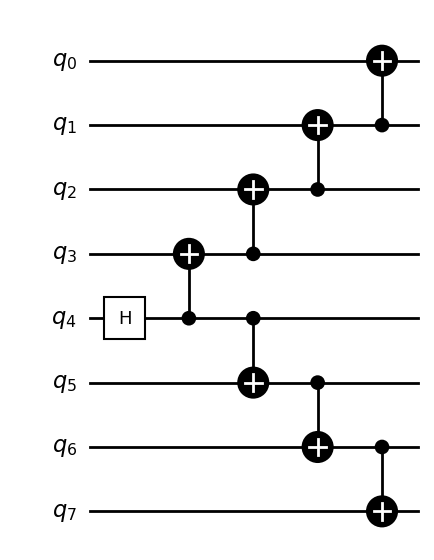

In [1]:
import numpy as np
from qiskit import QuantumCircuit

num_qubits = 8
qc = QuantumCircuit(num_qubits)
mid = num_qubits//2
qc.h(mid)
for i in range(mid,0,-1):
    qc.cx(i,i-1)
for i in range(mid,num_qubits-1):
    qc.cx(i,i+1)

qc.draw('mpl',style='bw',fold=-1)

### First we obtain ideal expectation value

In [2]:
from qiskit.result import sampled_expectation_value
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator

In [3]:
observable = SparsePauliOp('Z'*num_qubits)
shots = 5000

In [4]:
qc_copy = qc.copy()
qc_copy.measure_all()

counts_ideal = AerSimulator().run(qc_copy, shots=shots).result().get_counts()
ideal_expval = sampled_expectation_value(counts_ideal, observable)
ideal_expval

1.0

### Now run the same circuit with cutting

In [13]:
from circuit_knitting.cutting.cutqc import cut_circuit_wires

cuts = cut_circuit_wires(
    circuit=qc,
    method="automatic",
    max_subcircuit_width=5,
    max_cuts=2,
    num_subcircuits=[2],
    verbose=False
)

Exporting as a LP file to let you check the model that will be solved :  inf <class 'float'>
Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
CPXPARAM_TimeLimit                               300
Tried aggregator 3 times.
MIP Presolve eliminated 37 rows and 8 columns.
MIP Presolve modified 7 coefficients.
Aggregator did 41 substitutions.
Reduced MIP has 85 rows, 35 columns, and 257 nonzeros.
Reduced MIP has 30 binaries, 5 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.60 ticks)
Found incumbent of value 1.000000 after 0.02 sec. (0.87 ticks)
Probing fixed 4 vars, tightened 0 bounds.
Probing changed sense of 4 constraints.
Probing time = 0.00 sec. (0.14 ticks)
Cover probing fixed 0 vars, tightened 3 bounds.
Tried aggregator 2 times.
MIP Presolve eliminated 34 rows and 10 columns.
MIP Presolve modified 20 coefficients.
Aggregator did 4 substitutions.
Reduced MIP has 47 rows, 21 columns, and 151 nonzeros.
Reduced MIP h

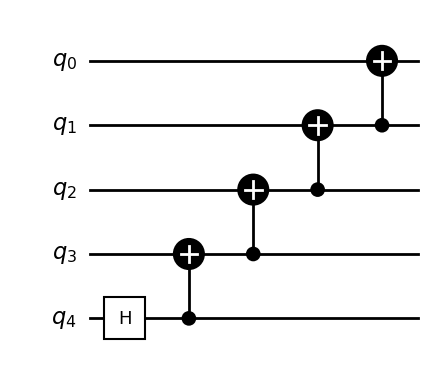

In [14]:
cuts["subcircuits"][0].draw('mpl',style='bw',fold=-1)

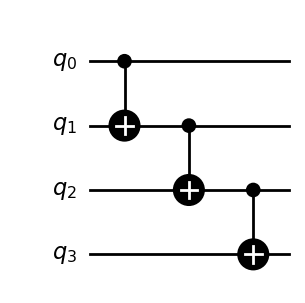

In [15]:
cuts["subcircuits"][1].draw('mpl',style='bw',fold=-1)

In [25]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer.noise import NoiseModel

In [26]:
service = QiskitRuntimeService()
backend = service.get_backend('ibm_brisbane')

In [27]:
noise_model = NoiseModel.from_backend(backend)

In [28]:
options = Options()
options.simulator.noise_model = noise_model
options.execution.shots = 10000
options.resilience_level = 1

In [29]:
backend_names = ["ibmq_qasm_simulator"] * 2

In [30]:
from circuit_knitting.cutting.cutqc import evaluate_subcircuits

In [ ]:
subcircuit_instance_probabilities = evaluate_subcircuits(cuts,
                                                         service=service,
                                                        backend_names=backend_names,
                                                        options=options,
                                                         )

In [20]:
from circuit_knitting.cutting.cutqc import (
    reconstruct_full_distribution,
)

reconstructed_probabilities = reconstruct_full_distribution(
    qc, subcircuit_instance_probabilities, cuts
)

In [21]:
reconstructed_probabilities

array([ 4.0052936e-01,  1.1680680e-02,  3.5279800e-03,  1.1000000e-07,
        1.2947620e-02,  6.3374000e-04,  4.5296000e-04,  1.8147000e-04,
        1.2401140e-02,  9.1130000e-05,  3.4000000e-07,  9.6600000e-05,
        3.6144000e-04,  9.0210000e-05,  1.7866000e-04,  1.0213260e-02,
        1.0131000e-02,  2.9544000e-04,  8.9490000e-05, -4.5000000e-08,
        3.2807000e-04,  1.5940000e-05,  1.1480000e-05,  4.5950000e-06,
        3.1322000e-04,  2.3950000e-06,  1.2000000e-07,  2.8900000e-06,
        8.8000000e-06,  1.6450000e-06,  4.0400000e-06,  2.5465000e-04,
        4.1182500e-03,  1.1972000e-04,  3.6310000e-05,  2.5000000e-08,
        1.3240000e-04,  6.5600000e-06,  4.6100000e-06,  2.0150000e-06,
        1.2774000e-04,  8.2500000e-07, -9.0000000e-08,  3.4000000e-07,
        3.9900000e-06,  1.4050000e-06,  2.5100000e-06,  1.0618000e-04,
        1.5463000e-04,  4.1200000e-06,  1.7700000e-06,  4.5500000e-07,
        4.3200000e-06,  1.6000000e-07,  4.3000000e-07,  2.3825000e-05,
      

In [22]:
from qiskit.result import ProbDistribution

reconstructed_distribution = {
    i: prob for i, prob in enumerate(reconstructed_probabilities)
}

# Represent states as bitstrings (instead of ints)
reconstructed_dict_bitstring = ProbDistribution(
    data=reconstructed_distribution
).binary_probabilities(num_bits=num_qubits)

In [23]:
reconstructed_dict_bitstring

{'00000000': 0.40052936000000006,
 '00000001': 0.011680679999999999,
 '00000010': 0.00352798,
 '00000011': 1.0999999999999725e-07,
 '00000100': 0.01294762,
 '00000101': 0.00063374,
 '00000110': 0.00045296000000000003,
 '00000111': 0.00018147000000000042,
 '00001000': 0.012401140000000001,
 '00001001': 9.113e-05,
 '00001010': 3.400000000000408e-07,
 '00001011': 9.659999999999877e-05,
 '00001100': 0.00036144,
 '00001101': 9.020999999999964e-05,
 '00001110': 0.00017865999999999976,
 '00001111': 0.010213260000000002,
 '00010000': 0.010131,
 '00010001': 0.00029544,
 '00010010': 8.949000000000001e-05,
 '00010011': -4.499999999999999e-08,
 '00010100': 0.00032807,
 '00010101': 1.594e-05,
 '00010110': 1.148e-05,
 '00010111': 4.595000000000006e-06,
 '00011000': 0.00031322,
 '00011001': 2.3950000000000004e-06,
 '00011010': 1.2000000000000055e-07,
 '00011011': 2.8900000000000215e-06,
 '00011100': 8.8e-06,
 '00011101': 1.6449999999999953e-06,
 '00011110': 4.039999999999995e-06,
 '00011111': 0.00025

In [24]:
cut_expval = sampled_expectation_value(reconstructed_dict_bitstring, observable)
cut_expval

0.6667236200000002